In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini yükleme
df = pd.read_csv('/Users/emin/Desktop/Biyoinformatik/dataset.csv')

# Sleep Disorder sütunundaki boş değerleri 'None' stringi ile dolduralım
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# İlk 5 satırı görüntüleme
print("Veri Setinin İlk 5 Satırı:")
print(df.head())

print("\nVeri Seti Bilgileri:")
print(df.info())

Veri Setinin İlk 5 Satırı:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200           None  
1      

In [26]:
# Kan Basıncını Ayrıştırma
if 'Blood Pressure' in df.columns:
    df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)
    df['Systolic_BP'] = df['Systolic_BP'].astype(int)
    df['Diastolic_BP'] = df['Diastolic_BP'].astype(int)
    df = df.drop(columns=['Blood Pressure'])

# Uyku Bozukluklarını Ayrıştırma (GELİŞMİŞ ANALİZ)
# Basit 0,1,2 kodlaması yerine, her hastalık için ayrı 1/0 sütunları oluşturuyoruz.
# Bu sayede korelasyon analizi çok daha doğru sonuç verecektir.

# 1. Insomnia Varlığı
df['Has_Insomnia'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Insomnia' else 0)

# 2. Uyku Apnesi Varlığı
df['Has_Sleep_Apnea'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Sleep Apnea' else 0)

# 3. Herhangi Bir Bozukluk Varlığı (None olmayanlar)
df['Has_Any_Disorder'] = df['Sleep Disorder'].apply(lambda x: 0 if x == 'None' else 1)

print("\nYeni Hastalık Gösterge Sütunları Eklendi:")
print(df[['Sleep Disorder', 'Has_Insomnia', 'Has_Sleep_Apnea', 'Has_Any_Disorder']].head())


Yeni Hastalık Gösterge Sütunları Eklendi:
  Sleep Disorder  Has_Insomnia  Has_Sleep_Apnea  Has_Any_Disorder
0           None             0                0                 0
1           None             0                0                 0
2           None             0                0                 0
3    Sleep Apnea             0                1                 1
4    Sleep Apnea             0                1                 1


In [27]:
# --- DÜZELTME VE İYİLEŞTİRME ---

# 1. Person ID'yi Çıkarma (Analiz için gereksiz)
if 'Person ID' in df.columns:
    df.drop(columns=['Person ID'], inplace=True)
    print("Person ID sütunu çıkarıldı.")

# 2. BMI Kategorisi Düzeltme ("Normal Weight" -> "Normal" olarak birleştirilmeli)
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

# 3. BMI Kategorisi Bilinçli Kodlama (Ordinal Encoding)
# Alfabetik sıra yerine Tıbbi Sıralama kullanılmalı: Normal < Overweight < Obese
bmi_mapping = {'Normal': 0, 'Overweight': 1, 'Obese': 2}
df['BMI Category'] = df['BMI Category'].map(bmi_mapping)

# 4. Diğer Kategorik Verileri Sayısallaştırma (Gender ve Occupation için)
categorical_cols = ['Gender', 'Occupation']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes

print("Veri temizleme ve kodlama tamamlandı.")
print(df.head())

Person ID sütunu çıkarıldı.
Veri temizleme ve kodlama tamamlandı.
   Gender  Age  Occupation  Sleep Duration  Quality of Sleep  \
0       1   27           9             6.1                 6   
1       1   28           1             6.2                 6   
2       1   28           1             6.2                 6   
3       1   28           6             5.9                 4   
4       1   28           6             5.9                 4   

   Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
0                       42             6             1          77   
1                       60             8             0          75   
2                       60             8             0          75   
3                       30             8             2          85   
4                       30             8             2          85   

   Daily Steps Sleep Disorder  Systolic_BP  Diastolic_BP  Has_Insomnia  \
0         4200           None          126            

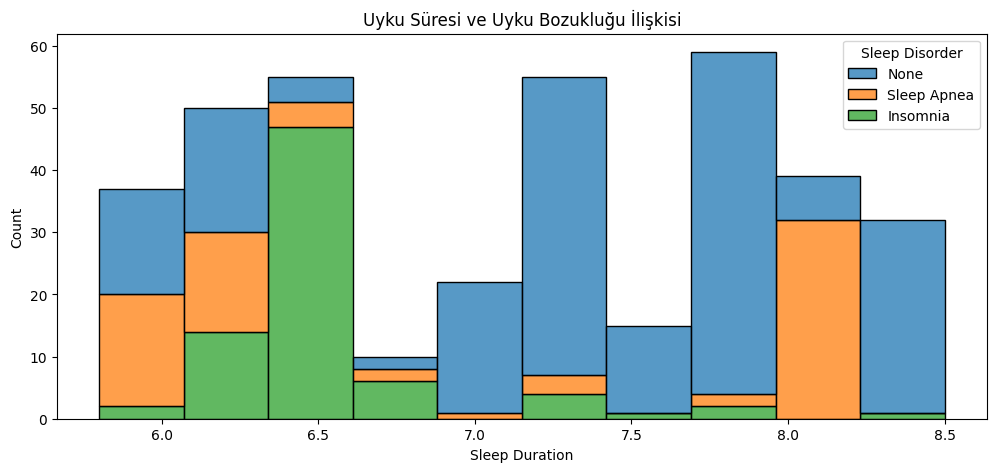

In [28]:
# Görselleştirme: Uyku Süresi ve Kalite Dağılımı
plt.figure(figsize=(12, 5))
sns.histplot(df, x="Sleep Duration", hue="Sleep Disorder", multiple="stack")
plt.title("Uyku Süresi ve Uyku Bozukluğu İlişkisi")
plt.show()

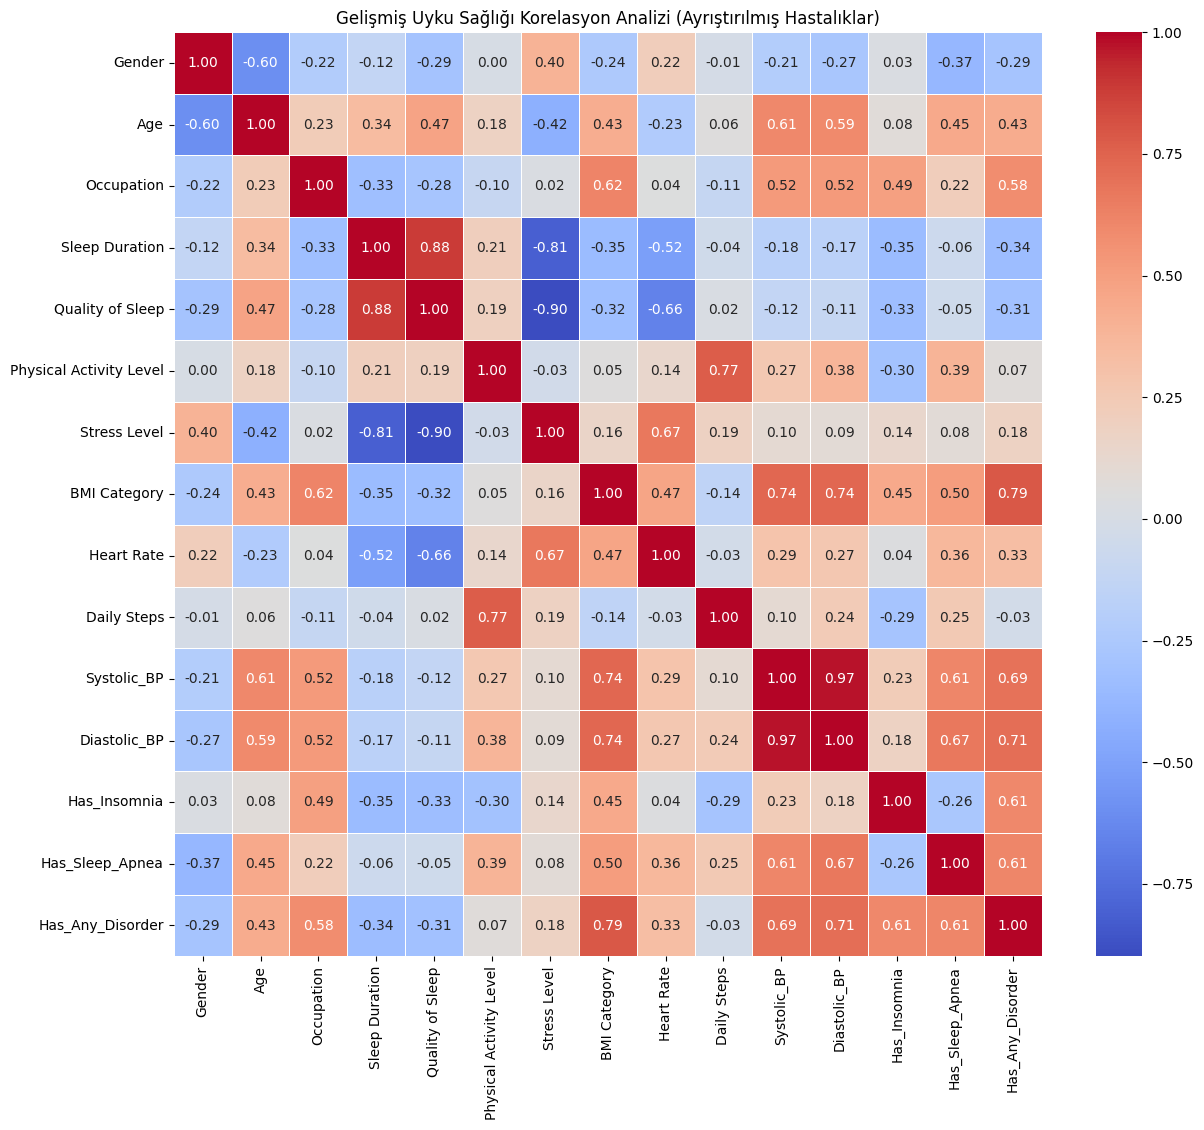


--- INSOMNIA (Uykusuzluk) ile En Güçlü İlişkiler ---
Has_Insomnia               1.000000
Has_Any_Disorder           0.605234
Occupation                 0.488584
BMI Category               0.451001
Systolic_BP                0.229359
Diastolic_BP               0.182657
Stress Level               0.139380
Age                        0.078478
Heart Rate                 0.037201
Gender                     0.027619
Has_Sleep_Apnea           -0.261378
Daily Steps               -0.288518
Physical Activity Level   -0.302352
Quality of Sleep          -0.332406
Sleep Duration            -0.347618
Name: Has_Insomnia, dtype: float64

--- SLEEP APNEA (Uyku Apnesi) ile En Güçlü İlişkiler ---
Has_Sleep_Apnea            1.000000
Diastolic_BP               0.673079
Systolic_BP                0.611389
Has_Any_Disorder           0.610180
BMI Category               0.503456
Age                        0.445719
Physical Activity Level    0.385533
Heart Rate                 0.363420
Daily Steps              

In [29]:
# Gelişmiş Korelasyon Analizi

# Sadece sayısal sütunları seçelim (Sleep Disorder hariç)
numeric_df = df.select_dtypes(include=['int64', 'int32', 'float64', 'int8'])
correlation_matrix = numeric_df.corr()

# Isı Haritası
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Gelişmiş Uyku Sağlığı Korelasyon Analizi (Ayrıştırılmış Hastalıklar)')
plt.show()

# Özel Analiz: Hangi faktörler Insomnia'yı tetikliyor?
print("\n--- INSOMNIA (Uykusuzluk) ile En Güçlü İlişkiler ---")
print(correlation_matrix['Has_Insomnia'].sort_values(ascending=False))

# Özel Analiz: Hangi faktörler Uyku Apnesi'ni tetikliyor?
print("\n--- SLEEP APNEA (Uyku Apnesi) ile En Güçlü İlişkiler ---")
print(correlation_matrix['Has_Sleep_Apnea'].sort_values(ascending=False))

# Özel Analiz: Stres ve Uyku Kalitesi İlişkisi
print("\n--- Stres Seviyesi ve Uyku Kalitesi Arasındaki İlişki ---")
print(f"Korelasyon Katsayısı: {correlation_matrix.loc['Stress Level', 'Quality of Sleep']:.4f}")

## 4. Makine Öğrenmesi ile Modelleme (Machine Learning Modeling)
Bu bölümde, veri setini kullanarak bir **Sınıflandırma Modeli** oluşturacağız. Amacımız, kişinin özelliklerine (Yaş, BMI, Stres vb.) bakarak **Uyku Bozukluğu (Sleep Disorder)** yaşayıp yaşamadığını veya hangi tür bozukluğu olduğunu tahmin etmektir.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Veri Hazırlığı
# Hedef değişkenimiz: 'Sleep Disorder'
# Bu sütun kategorik (None, Insomnia, Sleep Apnea) olduğu için sayısal hale getirmemiz gerekebilir
# Ancak Random Forest genelde label encoding ile çalışabilir.

# Veriyi (X) ve Hedefi (y) belirleyelim
# Not: 'Has_Insomnia', 'Has_Sleep_Apnea', 'Has_Any_Disorder' sütunlarını FEATURES'tan çıkarmalıyız.
# Çünkü bunlar doğrudan cevabı içeriyor (Data Leakage).
X = df.drop(columns=['Sleep Disorder', 'Has_Insomnia', 'Has_Sleep_Apnea', 'Has_Any_Disorder'])

# Hedef
y = df['Sleep Disorder']

# Split Data (Eğitim %80 - Test %20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (299, 12)
Test seti boyutu: (75, 12)


In [31]:
# Random Forest Sınıflandırıcısı Kurulumu ve Eğitimi
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred = rf_model.predict(X_test)

print("Model Eğitimi Tamamlandı.")

Model Eğitimi Tamamlandı.


### Model Performans Değerlendirmesi
Modelin **Doğruluk (Accuracy)** skorunu, **Karışıklık Matrisini (Confusion Matrix)** ve detaylı **Sınıflandırma Raporunu** inceleyelim.

Model Doğruluk Oranı (Accuracy): 88.00%
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



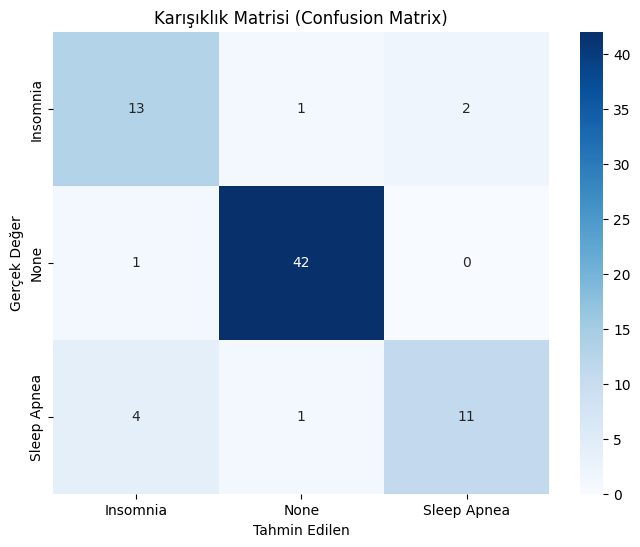

In [32]:
# 1. Doğruluk Skoru
acc = accuracy_score(y_test, y_pred)
print(f"Model Doğruluk Oranı (Accuracy): {acc:.2%}")

# 2. Sınıflandırma Raporu
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# 3. Karışıklık Matrisi Görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Karışıklık Matrisi (Confusion Matrix)')
plt.show()

### Özellik Önem Düzeyleri (Feature Importance)
Hangi faktörün uyku bozukluğu tahmininde daha etkili olduğunu görelim.

/var/folders/dg/z5xrss453fx9b_105ggbyg880000gn/T/ipykernel_11075/2592375325.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


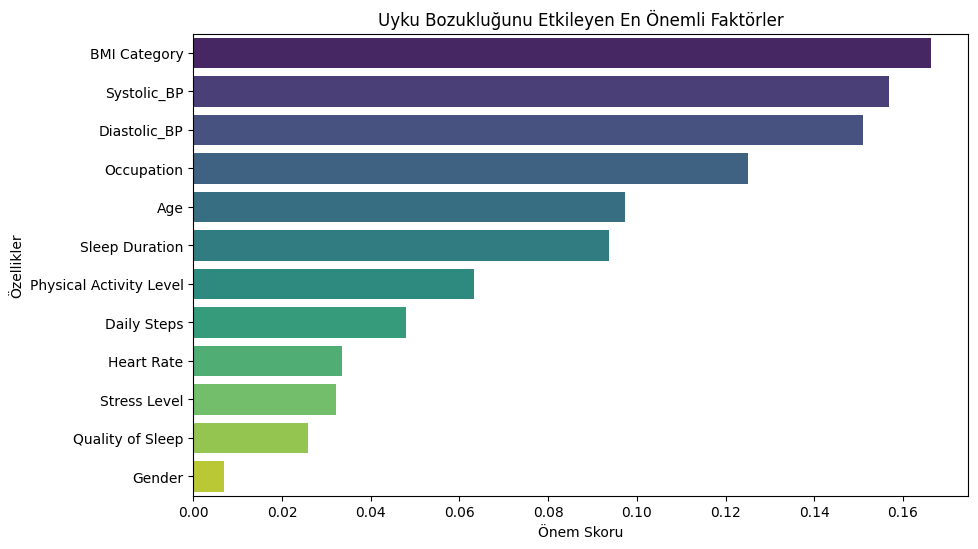

In [33]:
# Özellik Önemlerini Görselleştirme
import pandas as pd

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellikler')
plt.title('Uyku Bozukluğunu Etkileyen En Önemli Faktörler')
plt.show()